In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm  # Импорт функции напрямую
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from copy import deepcopy

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
DATA_DIR = '/content/drive/MyDrive/AI/CamVid'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [ ]:
num_classes = 32
image_size = 512

In [ ]:
class_dict = pd.read_csv(DATA_DIR + "/class_dict.csv")
color_mapping = {(row['r'], row['g'], row['b']): idx for idx, row in class_dict.iterrows()}

print(color_mapping)

{(64, 128, 64): 0, (192, 0, 128): 1, (0, 128, 192): 2, (0, 128, 64): 3, (128, 0, 0): 4, (64, 0, 128): 5, (64, 0, 192): 6, (192, 128, 64): 7, (192, 192, 128): 8, (64, 64, 128): 9, (128, 0, 192): 10, (192, 0, 64): 11, (128, 128, 64): 12, (192, 0, 192): 13, (128, 64, 64): 14, (64, 192, 128): 15, (64, 64, 0): 16, (128, 64, 128): 17, (128, 128, 192): 18, (0, 0, 192): 19, (192, 128, 128): 20, (128, 128, 128): 21, (64, 128, 192): 22, (0, 0, 64): 23, (0, 64, 64): 24, (192, 64, 128): 25, (128, 128, 0): 26, (192, 128, 192): 27, (64, 0, 64): 28, (192, 192, 0): 29, (0, 0, 0): 30, (64, 192, 0): 31}


In [ ]:
class CamVidDataset(Dataset):
    def __init__(self, image_dir, label_dir, color_mapping, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.color_mapping = color_mapping
        self.transform = transform
        self.image_files = sorted([os.path.join(image_dir, f)
                                   for f in os.listdir(image_dir)
                                   if f.endswith('.png')])
        self.label_files = sorted([os.path.join(label_dir, f)
                                   for f in os.listdir(label_dir)
                                   if f.endswith('.png')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_files[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = cv2.imread(self.label_files[idx])
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
        label = self.convert_to_class(label)

        if self.transform:
            augmented = self.transform(image=image, mask=label)
            image = augmented['image']
            label = augmented['mask']

        return image, label.long()

    def convert_to_class(self, label):
        class_mask = np.zeros((label.shape[0], label.shape[1]), dtype=int)

        for rgb, class_idx in self.color_mapping.items():
            mask = (label[:, :, 0] == rgb[0]) & (label[:, :, 1] == rgb[1]) & (label[:, :, 2] == rgb[2])
            class_mask[mask] = class_idx

        return class_mask

In [ ]:
def get_transform(train=True):
    if train:
      return A.Compose([
          A.Resize(image_size, image_size),
          A.HorizontalFlip(p=0.3),
          A.VerticalFlip(p=0.2),
          A.Rotate(limit=30, p=0.4),
          A.GaussianBlur(p=0.3),
          A.GaussNoise(std_range=[0.1, 0.2], p=0.2),
          A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
          ToTensorV2(),
      ])
    else:
        return A.Compose([
            A.Resize(image_size, image_size),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])

In [ ]:
train_dataset = CamVidDataset(
                  x_train_dir,
                  y_train_dir,
                  color_mapping,
                  transform=get_transform(train=True))

val_dataset = CamVidDataset(
                  x_valid_dir,
                  y_valid_dir,
                  color_mapping,
                  transform=get_transform(train=False))

test_dataset = CamVidDataset(
                  x_test_dir,
                  y_test_dir,
                  color_mapping,
                  transform=get_transform(train=False))

In [ ]:
def visualize_samples(dataset, color_mapping, num_samples=3):
    reverse_color_mapping = {v: k for k, v in color_mapping.items()}

    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))

    for i in range(num_samples):
        image, label = dataset[i]
        image = image.permute(1, 2, 0).numpy()
        label = label.numpy()


        label_rgb = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
        for class_idx, rgb in reverse_color_mapping.items():
            label_rgb[label == class_idx] = rgb

        axs[i, 0].imshow(image)
        axs[i, 0].set_title(f'Sample {i + 1} - Image')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(label_rgb)
        axs[i, 1].set_title(f'Sample {i + 1} - Label')
        axs[i, 1].axis('off')


    plt.tight_layout()
    plt.show()

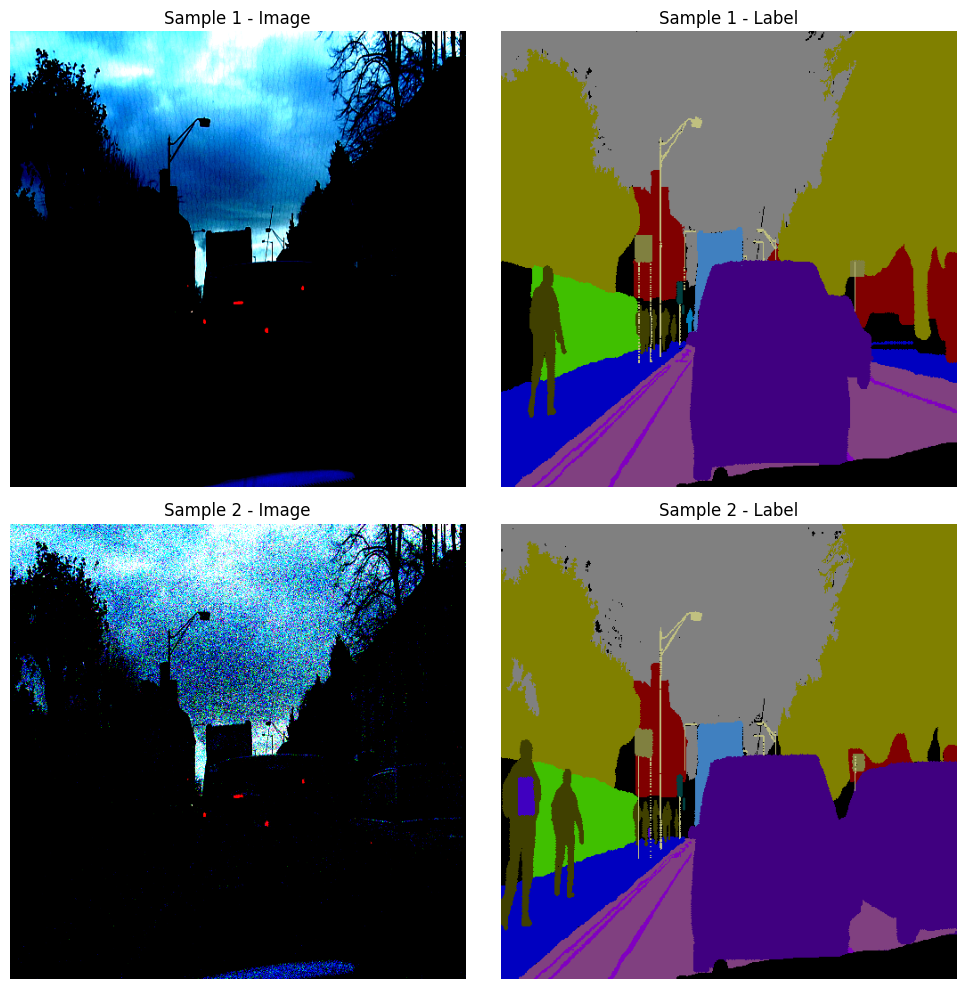

In [ ]:
visualize_samples(train_dataset,color_mapping, num_samples=2)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4,
                          shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4,
                        shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4,
                         shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
from torchvision.models.segmentation import fcn_resnet50

model = fcn_resnet50(pretrained=True)

model.classifier = torch.nn.Sequential(
    torch.nn.Conv2d(2048, num_classes, kernel_size=1)
)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:00<00:00, 185MB/s]


In [ ]:
model

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [ ]:
def val_epoch(model, dataloader, criterion, device):
    model.eval()

    running_loss = 0.0

    correct_pixels = 0
    total_pixels = 0

    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

    dice_per_class = np.zeros(num_classes)
    total_counts = np.zeros(num_classes)
    smooth = 1e-6

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Validating", leave=True)

        for images, masks in progress_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)["out"]
            loss = criterion(outputs, masks)

            preds = torch.argmax(outputs, dim=1)
            correct_pixels += (preds == masks).sum().item()
            total_pixels += masks.numel()

            # Update confusion matrix
            masks_np = masks.cpu().numpy()
            preds_np = preds.cpu().numpy()
            for pred, mask in zip(preds_np, masks_np):
                conf_matrix += confusion_matrix(mask.flatten(),
                                             pred.flatten(),
                                             labels=np.arange(num_classes))

            # Calculate Dice
            for class_id in range(num_classes):
                true_pos = np.sum((preds_np == class_id) & (masks_np == class_id))
                false_pos = np.sum((preds_np == class_id) & (masks_np != class_id))
                false_neg = np.sum((preds_np != class_id) & (masks_np == class_id))

                dice = (2 * true_pos + smooth) / (2 * true_pos + false_pos + false_neg + smooth)
                dice_per_class[class_id] += dice
                total_counts[class_id] += 1

            running_loss += loss.item()
            progress_bar.set_postfix({"val_loss": f"{loss.item():.4f}"})

    # Calculate final metrics
    epoch_loss = running_loss / len(dataloader)
    pixel_accuracy = correct_pixels / total_pixels

    # Calculate IoU
    intersection = np.diag(conf_matrix)
    union = conf_matrix.sum(axis=1) + conf_matrix.sum(axis=0) - intersection
    iou_per_class = intersection / (union + 1e-8)
    mean_iou = np.nanmean(iou_per_class)

    # Calculate Dice
    dice_per_class /= total_counts
    mean_dice = np.nanmean(dice_per_class)

    return epoch_loss, pixel_accuracy, iou_per_class, mean_iou, dice_per_class, mean_dice

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()

    running_loss = 0.0

    correct_pixels = 0
    total_pixels = 0

    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

    progress_bar = tqdm(dataloader, desc="Training", leave=True)

    for images, masks in progress_bar:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)["out"]
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate metrics
        preds = torch.argmax(outputs, dim=1)
        correct_pixels += (preds == masks).sum().item()
        total_pixels += masks.numel()

        # Update confusion matrix
        masks_np = masks.cpu().numpy()
        preds_np = preds.cpu().numpy()
        for pred, mask in zip(preds_np, masks_np):
            conf_matrix += confusion_matrix(mask.flatten(),
                                         pred.flatten(),
                                         labels=np.arange(num_classes))

        running_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    # Calculate final metrics
    epoch_loss = running_loss / len(dataloader)
    pixel_accuracy = correct_pixels / total_pixels

    # Calculate IoU
    intersection = np.diag(conf_matrix)
    union = conf_matrix.sum(axis=1) + conf_matrix.sum(axis=0) - intersection
    iou_per_class = intersection / (union + 1e-8)
    mean_iou = np.nanmean(iou_per_class)

    return epoch_loss, pixel_accuracy, iou_per_class, mean_iou

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, mode='max'):
        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, current_score, model):
        if self.best_score is None:
            self.best_score = current_score
            self.best_model_state = deepcopy(model.state_dict())
        elif ((self.mode == 'max' and current_score < self.best_score + self.delta) or
              (self.mode == 'min' and current_score > self.best_score - self.delta)):
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = current_score
            self.best_model_state = deepcopy(model.state_dict())
            self.counter = 0


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
               device, num_classes, num_epochs=10,
               early_stopping_patience=5):
    early_stopping = EarlyStopping(
        patience=early_stopping_patience,
        mode='max',
        delta=0.001
    )

    history = {
        'train_loss': [], 'train_acc': [], 'train_iou': [],
        'val_loss': [], 'val_acc': [], 'val_iou': [], 'val_dice': []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training
        train_loss, train_acc, train_iou_per_class, train_mean_iou = train_epoch(
            model, train_loader, criterion, optimizer, device)

        # Validation
        val_loss, val_acc, val_iou_per_class, val_mean_iou, val_dice_per_class, val_mean_dice = val_epoch(
            model, val_loader, criterion, device)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_iou'].append(train_mean_iou)

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_iou'].append(val_mean_iou)
        history['val_dice'].append(val_mean_dice)

        # Print epoch summary
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | mIoU: {train_mean_iou:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | mIoU: {val_mean_iou:.4f} | Dice: {val_mean_dice:.4f}")

        # Early Stopping check
        early_stopping(val_mean_iou, model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            print(f"Best validation mIoU: {early_stopping.best_score:.4f}")
            model.load_state_dict(early_stopping.best_model_state)
            break

    return history

In [ ]:
history = train_model(
    model, train_loader, val_loader, criterion,
    optimizer, device, num_classes,
    num_epochs=50
)


Epoch 1/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 1.1072 | Acc: 0.7409 | mIoU: 0.1420
Val Loss: 0.6266 | Acc: 0.8283 | mIoU: 0.1779 | Dice: 0.5559

Epoch 2/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.6226 | Acc: 0.8221 | mIoU: 0.2194
Val Loss: 0.4995 | Acc: 0.8570 | mIoU: 0.2549 | Dice: 0.6065

Epoch 3/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.5274 | Acc: 0.8445 | mIoU: 0.2681
Val Loss: 0.4416 | Acc: 0.8720 | mIoU: 0.2878 | Dice: 0.6251

Epoch 4/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.4757 | Acc: 0.8569 | mIoU: 0.2914
Val Loss: 0.4169 | Acc: 0.8770 | mIoU: 0.2970 | Dice: 0.6339

Epoch 5/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.4237 | Acc: 0.8697 | mIoU: 0.3170
Val Loss: 0.3879 | Acc: 0.8819 | mIoU: 0.3181 | Dice: 0.6408

Epoch 6/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.4004 | Acc: 0.8754 | mIoU: 0.3387
Val Loss: 0.4102 | Acc: 0.8745 | mIoU: 0.3202 | Dice: 0.6402

Epoch 7/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.3829 | Acc: 0.8797 | mIoU: 0.3561
Val Loss: 0.3532 | Acc: 0.8911 | mIoU: 0.3596 | Dice: 0.6570

Epoch 8/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.3493 | Acc: 0.8887 | mIoU: 0.3852
Val Loss: 0.3333 | Acc: 0.8939 | mIoU: 0.3673 | Dice: 0.6616

Epoch 9/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.3441 | Acc: 0.8896 | mIoU: 0.3975
Val Loss: 0.3399 | Acc: 0.8929 | mIoU: 0.3797 | Dice: 0.6627

Epoch 10/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.3327 | Acc: 0.8942 | mIoU: 0.4082
Val Loss: 0.3283 | Acc: 0.8965 | mIoU: 0.3782 | Dice: 0.6837
EarlyStopping counter: 1/5

Epoch 11/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.3483 | Acc: 0.8898 | mIoU: 0.3960
Val Loss: 0.3255 | Acc: 0.8962 | mIoU: 0.3794 | Dice: 0.6647
EarlyStopping counter: 2/5

Epoch 12/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.3116 | Acc: 0.8992 | mIoU: 0.4198
Val Loss: 0.3084 | Acc: 0.9006 | mIoU: 0.3957 | Dice: 0.6844

Epoch 13/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.2959 | Acc: 0.9021 | mIoU: 0.4352
Val Loss: 0.3160 | Acc: 0.8996 | mIoU: 0.3994 | Dice: 0.6784

Epoch 14/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.2883 | Acc: 0.9046 | mIoU: 0.4516
Val Loss: 0.3136 | Acc: 0.8994 | mIoU: 0.4078 | Dice: 0.6909

Epoch 15/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.2810 | Acc: 0.9071 | mIoU: 0.4642
Val Loss: 0.3142 | Acc: 0.8988 | mIoU: 0.4141 | Dice: 0.6721

Epoch 16/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.2797 | Acc: 0.9072 | mIoU: 0.4625
Val Loss: 0.3087 | Acc: 0.8990 | mIoU: 0.4139 | Dice: 0.6856
EarlyStopping counter: 1/5

Epoch 17/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.2607 | Acc: 0.9122 | mIoU: 0.4843
Val Loss: 0.3178 | Acc: 0.9012 | mIoU: 0.4125 | Dice: 0.6930
EarlyStopping counter: 2/5

Epoch 18/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.2653 | Acc: 0.9111 | mIoU: 0.4786
Val Loss: 0.3048 | Acc: 0.9028 | mIoU: 0.4271 | Dice: 0.7080

Epoch 19/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.2677 | Acc: 0.9110 | mIoU: 0.4863
Val Loss: 0.3059 | Acc: 0.9003 | mIoU: 0.4254 | Dice: 0.6934
EarlyStopping counter: 1/5

Epoch 20/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.2503 | Acc: 0.9149 | mIoU: 0.5129
Val Loss: 0.2995 | Acc: 0.9041 | mIoU: 0.4361 | Dice: 0.7039

Epoch 21/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.2527 | Acc: 0.9142 | mIoU: 0.5183
Val Loss: 0.2994 | Acc: 0.9039 | mIoU: 0.4401 | Dice: 0.6929

Epoch 22/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.2530 | Acc: 0.9138 | mIoU: 0.5045
Val Loss: 0.2893 | Acc: 0.9062 | mIoU: 0.4558 | Dice: 0.7069

Epoch 23/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.2424 | Acc: 0.9173 | mIoU: 0.5191
Val Loss: 0.2965 | Acc: 0.9050 | mIoU: 0.4609 | Dice: 0.7068

Epoch 24/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.2329 | Acc: 0.9196 | mIoU: 0.5158
Val Loss: 0.2901 | Acc: 0.9055 | mIoU: 0.4556 | Dice: 0.6919
EarlyStopping counter: 1/5

Epoch 25/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.2320 | Acc: 0.9202 | mIoU: 0.5393
Val Loss: 0.3065 | Acc: 0.9041 | mIoU: 0.4547 | Dice: 0.7006
EarlyStopping counter: 2/5

Epoch 26/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.2237 | Acc: 0.9222 | mIoU: 0.5464
Val Loss: 0.2968 | Acc: 0.9059 | mIoU: 0.4563 | Dice: 0.7006
EarlyStopping counter: 3/5

Epoch 27/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.2170 | Acc: 0.9241 | mIoU: 0.5638
Val Loss: 0.3351 | Acc: 0.8960 | mIoU: 0.4577 | Dice: 0.6881
EarlyStopping counter: 4/5

Epoch 28/50


Training:   0%|          | 0/93 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validating:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

Train Loss: 0.2329 | Acc: 0.9194 | mIoU: 0.5453
Val Loss: 0.3033 | Acc: 0.9049 | mIoU: 0.4522 | Dice: 0.7041
EarlyStopping counter: 5/5
Early stopping triggered at epoch 28
Best validation mIoU: 0.4609


In [ ]:
history

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(15, 10))

    # loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # IoU
    plt.subplot(2, 2, 3)
    plt.plot(history['train_iou'], label='Train mIoU')
    plt.plot(history['val_iou'], label='Validation mIoU')
    plt.title('Training and Validation mIoU')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.legend()

    # Dice
    plt.subplot(2, 2, 4)
    plt.plot(history['val_dice'], label='Validation Dice')
    plt.title('Validation Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.legend()

    plt.tight_layout()
    plt.show()

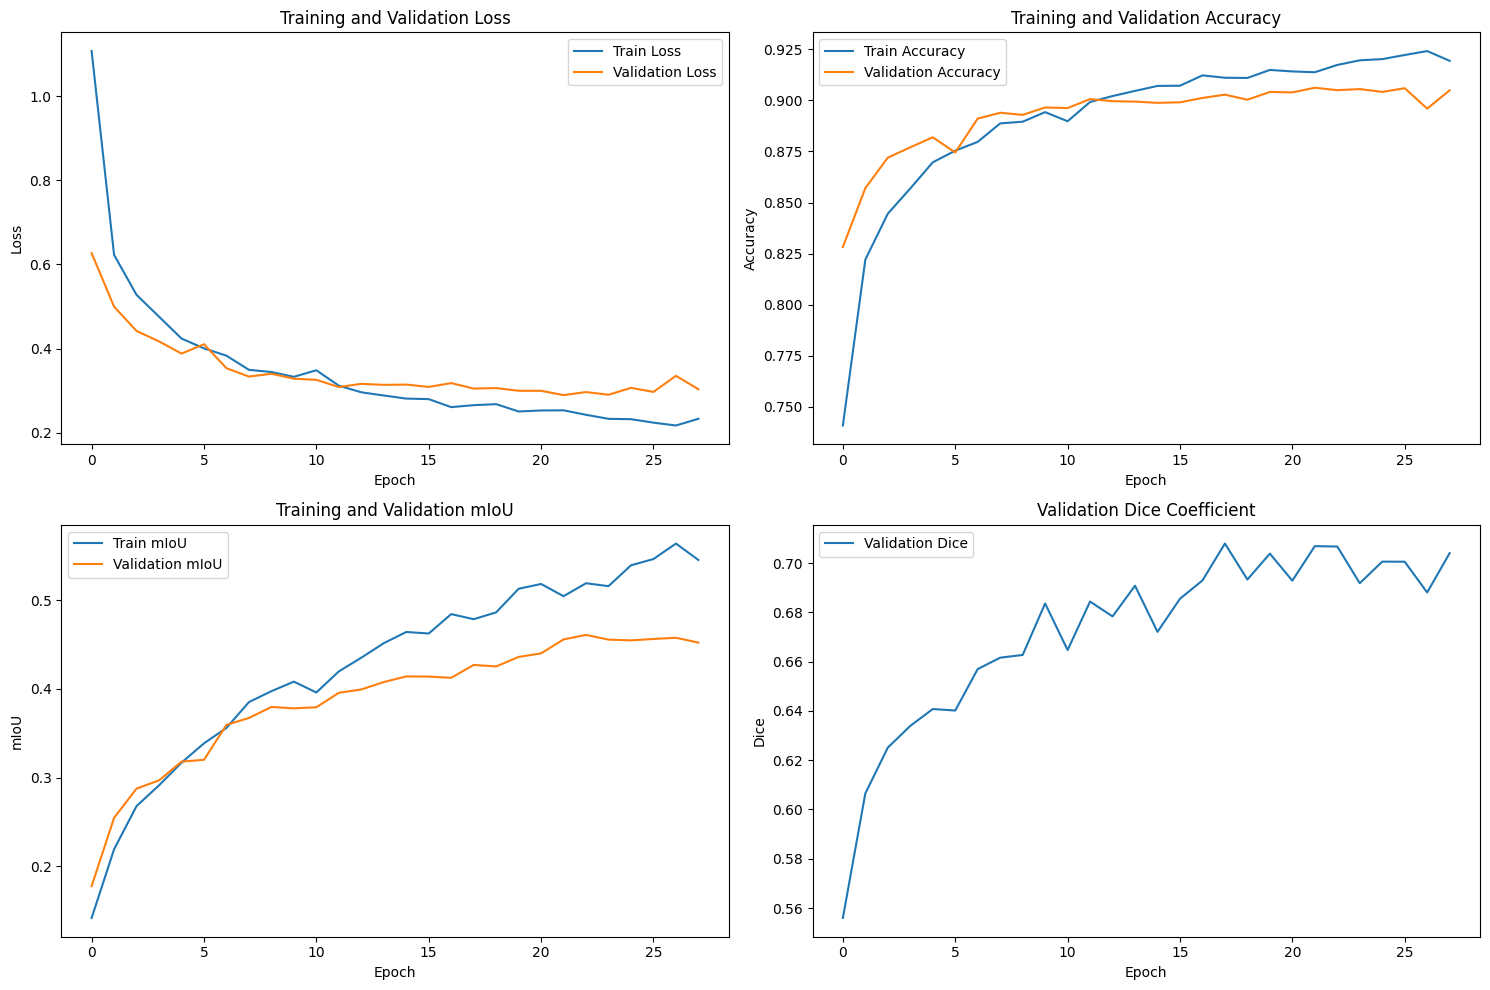

In [ ]:
plot_training_history(history)

In [ ]:
import json

In [ ]:
def save_history_to_json(history, filename=None):
    os.makedirs('training_history', exist_ok=True)
    filepath = os.path.join('training_history', filename)

    serializable_history = {}
    for key, value in history.items():
        if isinstance(value, (list, np.ndarray)):
            serializable_history[key] = [float(x) for x in value]
        else:
            serializable_history[key] = value

    with open(filepath, 'w') as f:
        json.dump(serializable_history, f, indent=4)

    print(f"История обучения сохранена в {filepath}")
    return filepath

In [ ]:
save_history_to_json(history, filename="try1.json")

История обучения сохранена в training_history/try1.json


'training_history/try1.json'

In [ ]:
torch.save(model.state_dict(), "fcn_resnet50_32cl.pth")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


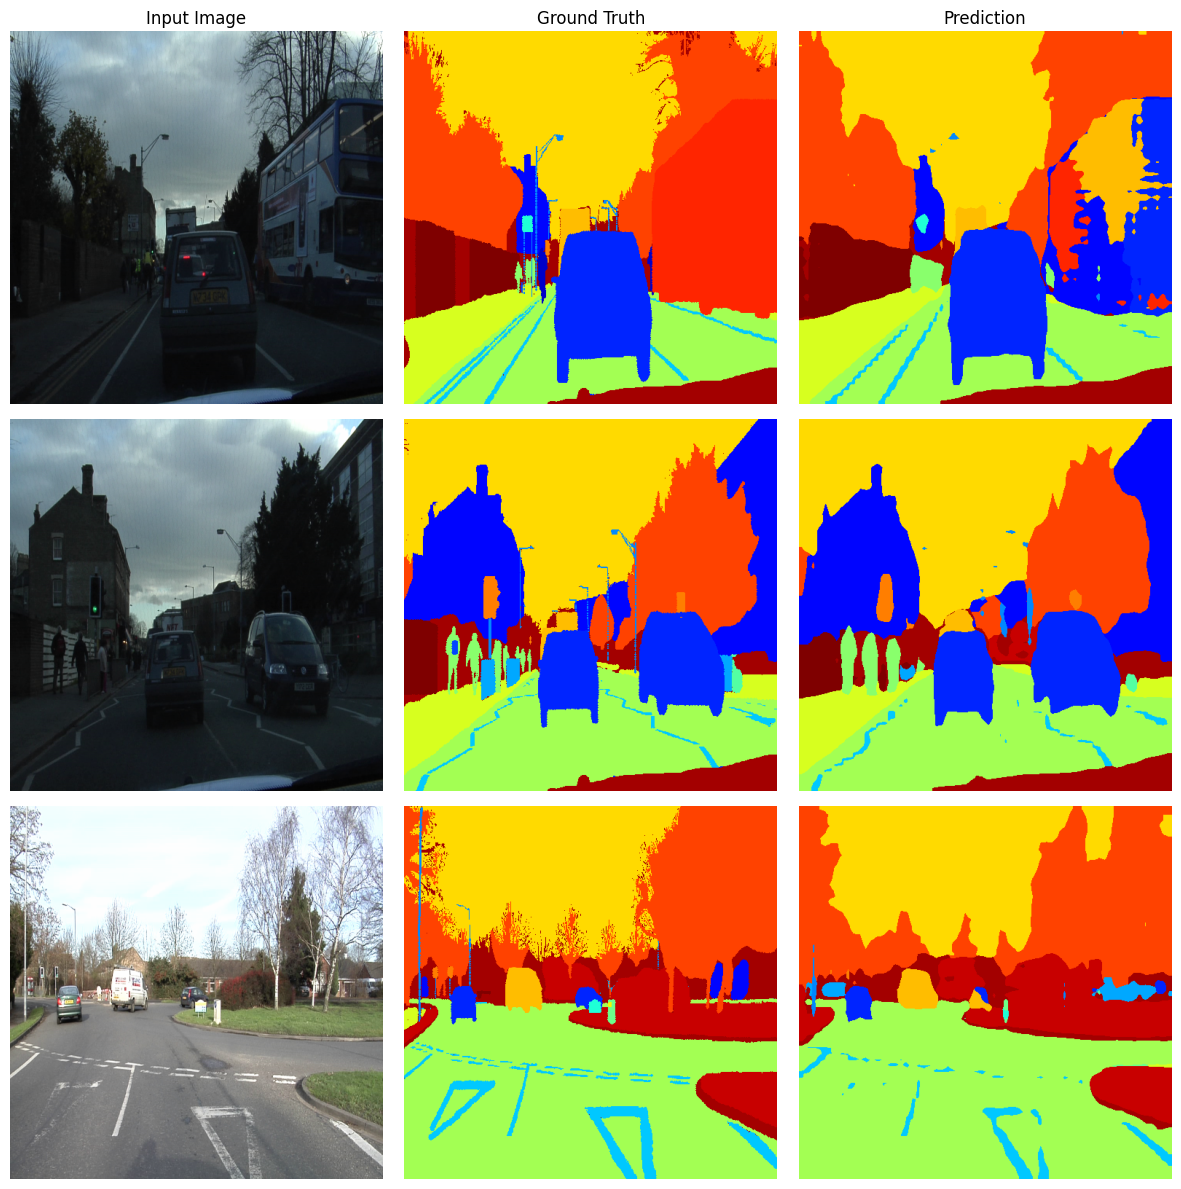

In [ ]:
def plot_results(model, dataloader, num_samples=3):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))
    axes[0, 0].set_title("Input Image")
    axes[0, 1].set_title("Ground Truth")
    axes[0, 2].set_title("Prediction")

    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            if i >= num_samples:
                break
            images = images.to("cuda")
            masks = masks.cpu().numpy()
            outputs = model(images)["out"]
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            img = images[0].cpu().permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)

            axes[i, 0].imshow(img)
            axes[i, 1].imshow(masks[0], cmap="jet", vmin=0, vmax=31)
            axes[i, 2].imshow(preds[0], cmap="jet", vmin=0, vmax=31)

            for ax in axes[i]:
                ax.axis("off")

    plt.tight_layout()
    plt.show()

plot_results(model, val_loader, num_samples=3)